**Zachary Torstrick**  
**Module 4**  
**ATMS 523**  
**Fall 2025**  

#### Submit this code as a pull request back to GitHub Classroom by the date and time listed in Canvas. For this assignment, use the ERA-5 *monthly mean* data from Copernicus Data Service.  

In [90]:
import os
import warnings

import cdsapi
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from eofs.xarray import Eof

### (1) Create a dataset that contains the monthly means of Sea Surface Temperature anomalies and total column water vapor from Jan 1979-Dec 2024 over the Pacific Basin (65°N to 65°S, 120°E to 60°W) masked out over land - save this to your computer. The data and land sea mask is available here: [https://cds.climate.copernicus.eu/datasets/reanalysis-era5-single-levels-monthly-means?tab=download](https://cds.climate.copernicus.eu/datasets/reanalysis-era5-single-levels-monthly-means?tab=download)

File era5_sst_tcwv_pacific.grib already exists.


<xarray.Dataset> Size: 2GB
Dimensions:     (time: 552, latitude: 521, longitude: 721)
Coordinates:
    number      int64 8B ...
  * time        (time) datetime64[ns] 4kB 1979-01-01 1979-02-01 ... 2024-12-01
    step        timedelta64[ns] 8B ...
    surface     float64 8B ...
  * latitude    (latitude) float64 4kB 65.0 64.75 64.5 ... -64.5 -64.75 -65.0
  * longitude   (longitude) float64 6kB 120.0 120.2 120.5 ... 299.5 299.8 300.0
    valid_time  (time) datetime64[ns] 4kB ...
Data variables:
    sst         (time, latitude, longitude) float32 829MB ...
    tcwv        (time, latitude, longitude) float32 829MB ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-10-24T23:58 GRIB to CDM+CF via cfgrib-0.9.1...

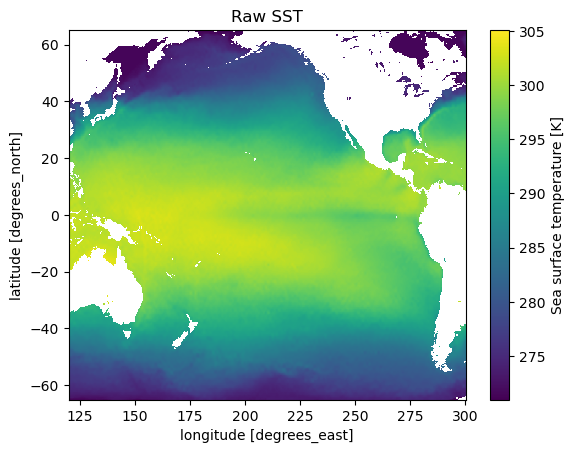

In [91]:
filename = "era5_sst_tcwv_pacific.grib"

# Download the file if it doesn't exist locally
if not os.path.exists(filename):
    dataset = "reanalysis-era5-single-levels-monthly-means"
    request = {
        "product_type": ["monthly_averaged_reanalysis"],
        "variable": [
            "sea_surface_temperature",
            "total_column_water_vapour"
        ],
        "year": [
            "1979", "1980", "1981",
            "1982", "1983", "1984",
            "1985", "1986", "1987",
            "1988", "1989", "1990",
            "1991", "1992", "1993",
            "1994", "1995", "1996",
            "1997", "1998", "1999",
            "2000", "2001", "2002",
            "2003", "2004", "2005",
            "2006", "2007", "2008",
            "2009", "2010", "2011",
            "2012", "2013", "2014",
            "2015", "2016", "2017",
            "2018", "2019", "2020",
            "2021", "2022", "2023",
            "2024"
        ],
        "month": [
            "01", "02", "03",
            "04", "05", "06",
            "07", "08", "09",
            "10", "11", "12"
        ],
        "time": ["00:00"],
        "data_format": "grib",
        "download_format": "unarchived",
        "area": [65, 120, -65, 300]  # 300°E = 60°W
    }

    client = cdsapi.Client()
    client.retrieve(dataset, request).download(target=filename)
else:
    print(f"File {filename} already exists.")

ds = xr.open_dataset(
    "era5_sst_tcwv_pacific.grib",
    engine="cfgrib"
)

# Check data
ds['sst'].isel(time=0).plot()
plt.title('Raw SST')

ds

### (2) From the dataset shown in 1, compute anomalies by deseasonalizing the data (remove the mean monthly anomaly from the annual mean from each point) and detrend the data. Then, standardize the SST anomalies.  Standardization means subtract the long term mean and divide by the standard deviation, which can be accomplished using the methods described here: [6.3. Preprocessing data &mdash; scikit-learn 1.1.2 documentation](https://scikit-learn.org/stable/modules/preprocessing.html)

In [92]:
def _time_as_float(time: xr.DataArray, time_dim: str) -> xr.DataArray:
    # numeric seconds since first timestamp (keeps numbers small)
    return (time - time.isel({time_dim: 0})).astype("timedelta64[s]").astype("int64").astype("float64")

def linear_detrend(obj: xr.DataArray | xr.Dataset, time_dim: str = "time") -> xr.DataArray | xr.Dataset:
    """
    Remove a linear trend y ~ s*(t - t̄_valid) + ȳ_valid at each grid point.
    Closed-form LS using reductions; dask-friendly; handles NaNs.
    """
    t = _time_as_float(obj[time_dim], time_dim)  # (time,)
    def _detrend_da(da: xr.DataArray) -> xr.DataArray:
        da = da.sortby(time_dim).astype("float32")
        if hasattr(da.data, "chunks"):
            da = da.chunk({time_dim: -1})  # one chunk along time
        mask = da.notnull()                                # (time, ...)
        t_b = t.broadcast_like(da)                         # (time, ...)
        t_mean_valid = t_b.where(mask).mean(time_dim, skipna=True)
        tc = t_b - t_mean_valid                            # centered time per point
        num = (da * tc).sum(time_dim, skipna=True)
        den = (tc**2).sum(time_dim, skipna=True)
        slope = xr.where(den > 0, num / den, 0.0)
        ybar  = da.mean(time_dim, skipna=True)
        trend = slope * (t_b - t_mean_valid) + ybar
        return (da - trend).astype("float32")
    return obj.map(_detrend_da) if isinstance(obj, xr.Dataset) else _detrend_da(obj)

def monthly_anom_and_z(
    detr: xr.DataArray | xr.Dataset,
    time_dim: str = "time",
    base_period: tuple[str, str] | None = None,
    ddof: int = 1,
    eps: float = 1e-6,
):
    """
    Remove monthly climatology and compute monthly z-scores.
    
    From linearly-detrended data, removes monthly climatological mean
    and computes standardized anomalies (z-scores).
    Returns (anom, z). Works for Dataset or DataArray.
    """
    if base_period is None:
        clim_src = detr
    else:
        clim_src = detr.sel({time_dim: slice(*base_period)})
    
    key = f"{time_dim}.month"

    clim_mean = clim_src.groupby(key).mean(time_dim, skipna=True)
    anom = detr.groupby(key) - clim_mean

    clim_std = clim_src.groupby(key).std(time_dim, skipna=True, ddof=ddof)
    safe_std = xr.where(clim_std > eps, clim_std, np.nan)
    z = anom.groupby(key) / safe_std
    
    return anom, z


# Suppress the degrees of freedom warning
warnings.filterwarnings('ignore', message='Degrees of freedom <= 0')

# Kept getting errors about different chunk sizes
ds = ds.unify_chunks()

detr = linear_detrend(
    ds[["sst", "tcwv"]],
    time_dim="time"
)
anom, z = monthly_anom_and_z(
    detr,
    time_dim="time"
)

print(type(z), list(z.data_vars))

<class 'xarray.core.dataset.Dataset'> ['sst', 'tcwv']


### (3) Perform an EOF analysis on the SST anomalies and plot a map of the first 5 EOFs, following M04N05.


In [93]:
warnings.filterwarnings(
    'ignore',
    category=UserWarning,
    module='cartopy'
)

sst_anom = anom['sst']

# Create an EOF solver. Square-root of cosine of latitude weights
# are applied before the computation of EOFs.
coslat = np.cos(np.deg2rad(sst_anom.coords['latitude'].values))
wgts = np.sqrt(coslat)[..., np.newaxis]
solver = Eof(
    sst_anom,
    weights=wgts
)

# Retrieve EOFs expressed as correlation with PC time series
eofs = solver.eofsAsCorrelation(neofs=5)
pcs = solver.pcs(
    npcs=2,
    pcscaling=1
)

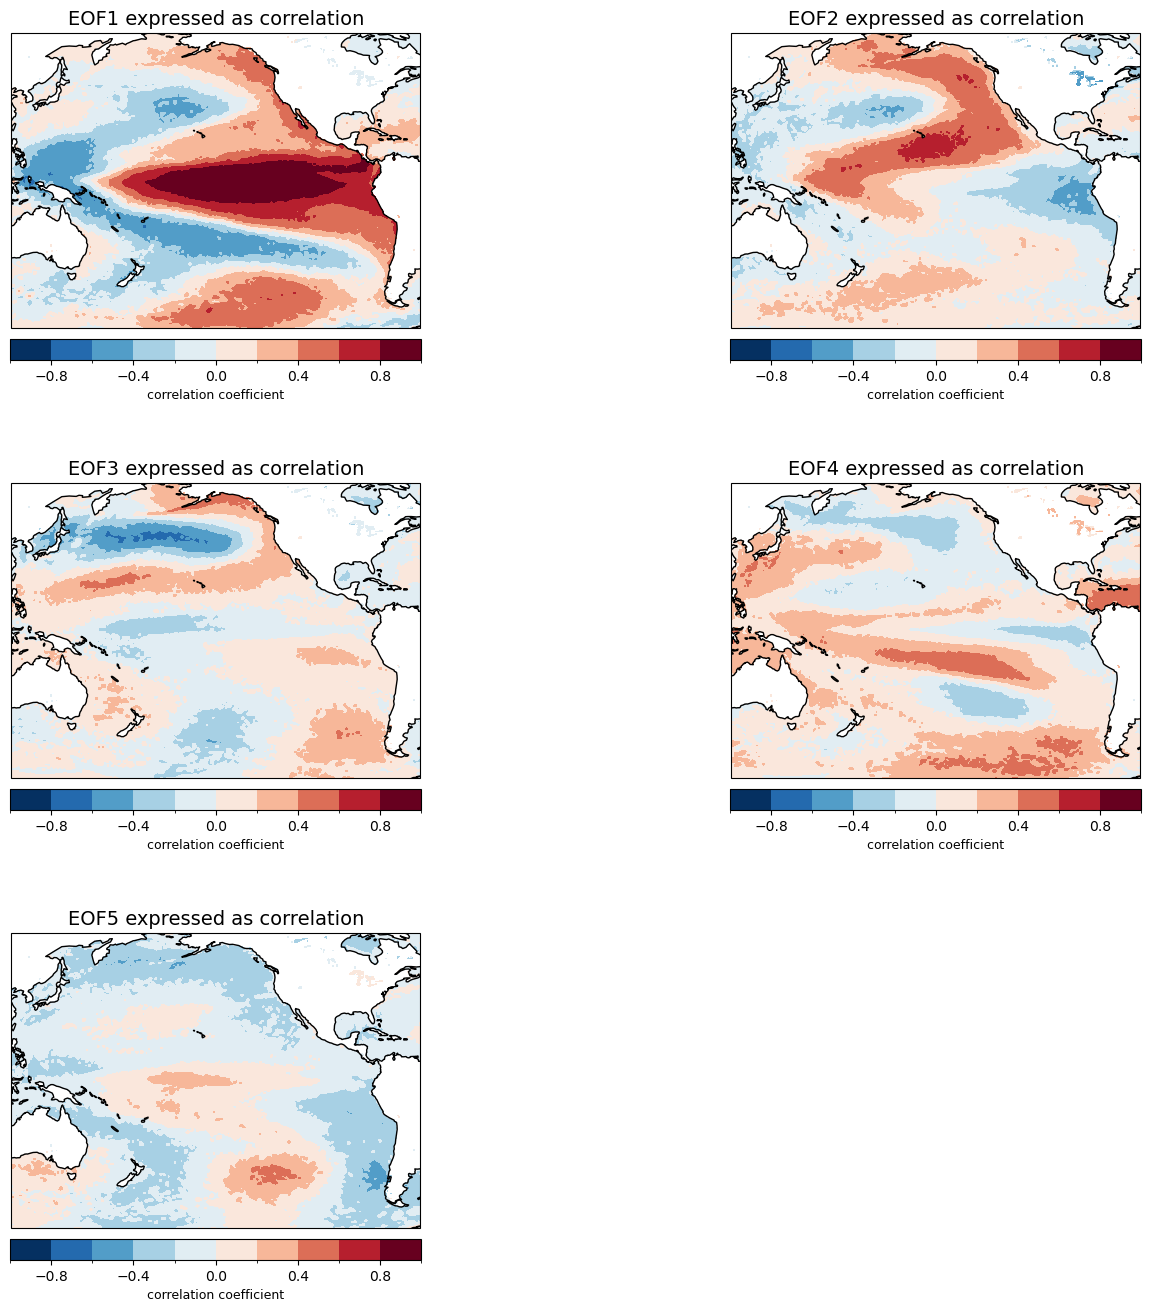

In [94]:
# Plot the EOFs as correlation in the Pacific domain.
projection = ccrs.PlateCarree(central_longitude=190)
fig, axes = plt.subplots(
    3,
    2,
    figsize=(16, 14),
    subplot_kw={'projection': projection}
)
axes = axes.flatten()

clevs = np.linspace(-1, 1, 11)

for i in range(5):
    ax = axes[i]
    
    # Set the map extent to match the data
    ax.set_extent([120, 300, -65, 65], crs=ccrs.PlateCarree())
    
    fill = eofs[i].plot.contourf(
        ax=ax,
        levels=clevs,
        cmap=plt.cm.RdBu_r,
        add_colorbar=False,
        transform=ccrs.PlateCarree()
    )
    ax.add_feature(
        cfeature.COASTLINE,
        color='k',
        edgecolor='k'
    )
    ax.set_title(
        f'EOF{i+1} expressed as correlation',
        fontsize=14
    )

    # Add colorbar
    cb = plt.colorbar(
        fill,
        ax=ax,
        orientation='horizontal',
        shrink=0.5715,
        pad=0.03
    )
    cb.set_label(
        'correlation coefficient',
        fontsize=9
    )

# Plot has 6 charts but we only show 5
axes[5].set_visible(False)

# Adjust spacing to fill white space
plt.subplots_adjust(
    left=0.05,
    right=0.95,
    top=0.95,
    bottom=0.05,
    hspace=0.25,
    wspace=0.0
)

### (4) Plot the percent of variance explained by the first 10 EOFs.


In [95]:
varfrac = solver.varianceFraction()

(4.464185504550119e-16, 0.24132317304611206)

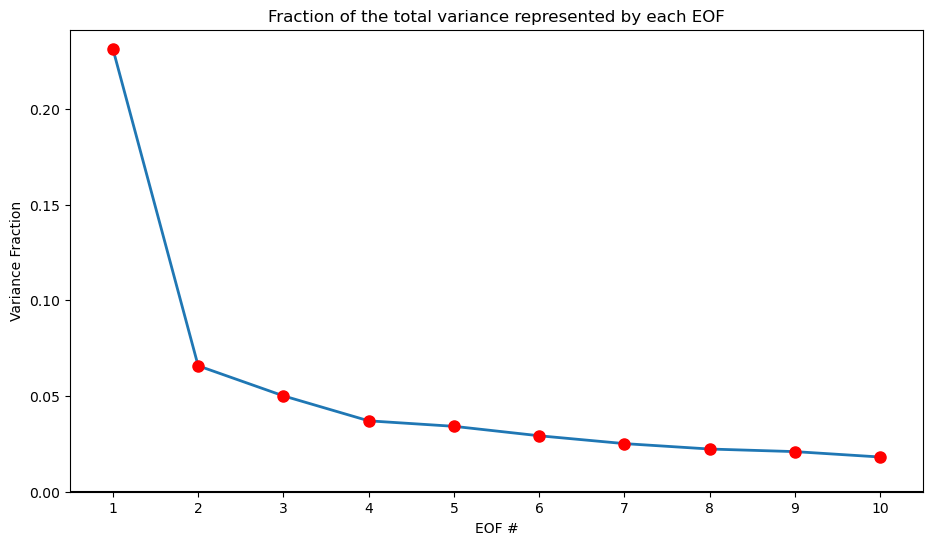

In [96]:
plt.figure(figsize=(11, 6))
eof_num = range(1, 11)
plt.plot(
    eof_num,
    varfrac[0:10],
    linewidth=2
)
plt.plot(
    eof_num,
    varfrac[0:10],
    linestyle='None',
    marker="o",
    color='r',
    markersize=8
)
plt.axhline(0, color='k')
plt.xticks(range(1, 16))
plt.title('Fraction of the total variance represented by each EOF')
plt.xlabel('EOF #')
plt.ylabel('Variance Fraction')
plt.xlim(0.5, 10.5)
plt.ylim(np.min(varfrac), np.max(varfrac) + 0.01)

In [97]:
# Compute cumulative variance
cumulative_variance = np.cumsum(varfrac)

# Print cumulative variance for first 10 EOFs
for i in range(10):
    print(f"First {i+1} EOFs explain {cumulative_variance[i]*100:.2f}% of variance")

First 1 EOFs explain 23.13% of variance
First 2 EOFs explain 29.71% of variance
First 3 EOFs explain 34.72% of variance
First 4 EOFs explain 38.42% of variance
First 5 EOFs explain 41.84% of variance
First 6 EOFs explain 44.76% of variance
First 7 EOFs explain 47.27% of variance
First 8 EOFs explain 49.51% of variance
First 9 EOFs explain 51.60% of variance
First 10 EOFs explain 53.41% of variance


### (5) Reconstruct the SST field using the first 5 EOFs and plot a map of the Pearson's correlation coefficient ([xarray.corr](https://docs.xarray.dev/en/stable/generated/xarray.corr.html)) of the reconstructed monthly time series (which will be "retrended" and "unstandardized") and the "observed" SST time series.

In [98]:
reconstruction = solver.reconstructedField(5)

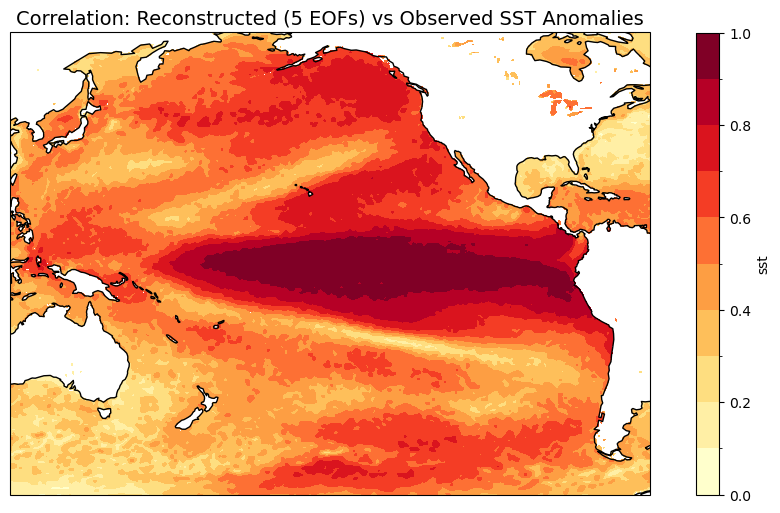

In [99]:
# Observed SST anomalies
observed = anom['sst']

# Compute correlation along time dimension at each grid point
correlation_map = xr.corr(
    reconstruction,
    observed,
    dim='time'
)

# Plot
fig = plt.figure(figsize=(12, 6))
projection = ccrs.PlateCarree(central_longitude=190)
ax = plt.axes(projection=projection)

clevs = np.linspace(0, 1, 11)
fill = correlation_map.plot.contourf(
    ax=ax,
    levels=clevs,
    cmap='YlOrRd',
    add_colorbar=True,
    transform=ccrs.PlateCarree()
)

ax.add_feature(
    cfeature.COASTLINE,
    color='k'
)
ax.set_title(
    'Correlation: Reconstructed (5 EOFs) vs Observed SST Anomalies',
    fontsize=14
)
plt.show()

### (6) Compute a map of the Pearson's correlation coefficient between SST EOF1 and monthly mean detrended, deseasonalized, and standardized monthly mean column water vapor anomalies (don't mask these over land for the plot).  See anything interesting?

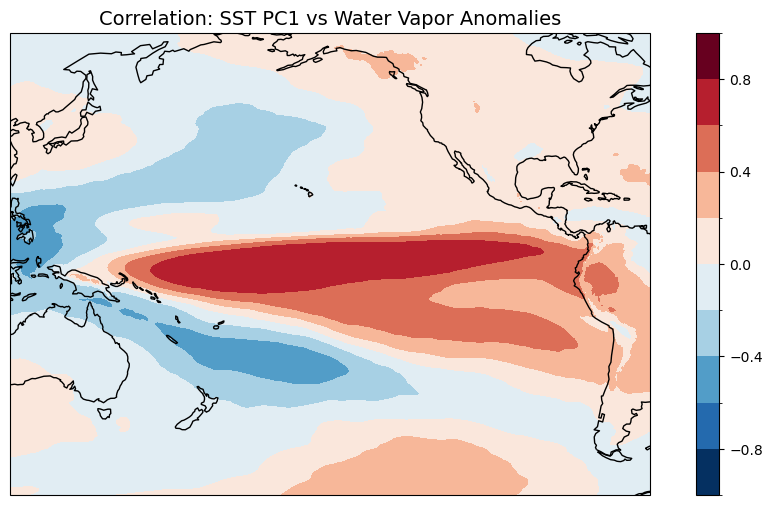

In [100]:
# Use standardized water vapor as requested
tcwv_standardized = z['tcwv']

# Get PC1 time series (not EOF1 spatial pattern!)
pc1 = pcs[:, 0]

# Compute correlation between PC1 time series and water vapor at each point
correlation_map = xr.corr(
    pc1,
    tcwv_standardized,
    dim='time'
)

# Plot
fig = plt.figure(figsize=(12, 6))
projection = ccrs.PlateCarree(central_longitude=190)
ax = plt.axes(projection=projection)

clevs = np.linspace(-1, 1, 11)
fill = correlation_map.plot.contourf(
    ax=ax,
    levels=clevs,
    cmap=plt.cm.RdBu_r,
    add_colorbar=True,
    transform=ccrs.PlateCarree()
)

ax.add_feature(
    cfeature.COASTLINE,
    color='k'
)
ax.set_title(
    'Correlation: SST PC1 vs Water Vapor Anomalies',
    fontsize=14
)
plt.show()
